# Heart Disease Prediction - Exploratory Analysis

In this notebook, we will explore a dataset containing clinical information about healthy patients and those with heart disease. We will perform some exploratory analysis to gain insights into the data and prepare it for modeling.


## Big Picture
- **Goal**: Predict whether a patient has heart disease or not
- **Uses cases (patients and hcp)**:
    - Improve quality of health services-- enable healthcare providers to diagnose patients with heart disease early and adminstering effective treatments. Reduce unnecessary treatments/tests for patients who are unlikely to have heart disease.
    - Identify the most important factors associated with heart disease. Remove tests/measurements that are not predictive to reduce patients' costs and time.
- **Use cases (marketing team)**:
    - Serve as a proof-of-concept: can we predict heart disease with clinical data that are obtainable from pathology labs and health care providers? If so, can we partner with these entities to obtain more data?
    - With more data, we may train a model to generate mean predicted probabilities of heart disease in a geographic area (e.g., HSA or census tract). This allow us to gauge the demand for Pfizer's products such as Vyndaqel and Vyndamax in specific geographic areas, which in turn inform the company's production and distribution plans, as well as marketing strategies at a more precise level.
    - Can we profile people who are most likely to have heart disease (do they have specific sociodemographic characterisitics? Do they get their health information from certain sources-- social media, blogs, doctors, friends and family)-- this allow us to target these patients  with more relevant marketing messages. 


In [87]:
'''common'''
import pandas as pd
import numpy as np
from collections import OrderedDict
import scipy.stats as stats
from pathlib import Path
from summarytools import dfSummary

'''visualization'''
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib inline
plt.style.use("fivethirtyeight")
plt.rcParams["font.size"] = 14
plt.rcParams["patch.edgecolor"]= "k"

import seaborn as sns

'''pandas options'''
# display maximum of 150 columns in a pandas dataframe
pd.options.display.max_columns = 150

In [88]:
# Custom modules
import src.data_manager as dm
import src.processing as pp
import src.utils as utils

In [89]:
# Reload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import data

In [90]:
raw = dm.load_data(Path("data","heart.csv")) 

In [91]:
raw.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


## Preprocess data
- Select data from the Cleveland database only
- Remove the dataset column
- If I want to perform binary classification, set num==0 to 0, and num>0 to 1

In [92]:
# Select data from Cleveland dataset and remove the dataset column
df = raw.copy().query("dataset=='Cleveland'").loc[:,raw.columns != "dataset"]

# Binarize the target variable
df["target"] = df["num"].apply(lambda x: 1 if x > 0 else 0)
# Remove the num column
df = df.loc[:,df.columns != "num"]

In [93]:
df.to_csv(Path("data","heart_preprocessed.csv"), index=False)

## Univariate analysis

In [94]:
df.head()

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,target
0,1,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,1
2,3,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [95]:
df.shape

(304, 15)

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 304 entries, 0 to 303
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        304 non-null    int64  
 1   age       304 non-null    int64  
 2   sex       304 non-null    object 
 3   cp        304 non-null    object 
 4   trestbps  304 non-null    float64
 5   chol      304 non-null    float64
 6   fbs       304 non-null    object 
 7   restecg   304 non-null    object 
 8   thalch    304 non-null    float64
 9   exang     304 non-null    object 
 10  oldpeak   304 non-null    float64
 11  slope     303 non-null    object 
 12  ca        299 non-null    float64
 13  thal      301 non-null    object 
 14  target    304 non-null    int64  
dtypes: float64(5), int64(3), object(7)
memory usage: 38.0+ KB


Saving figure target_distribution


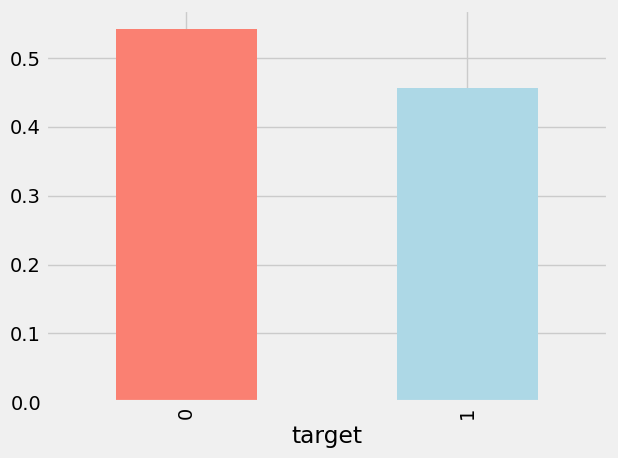

In [97]:
df.target.value_counts(normalize=True).plot(kind="bar", color=["salmon", "lightblue"])
dm.save_fig(fig_id= "target_distribution", image_directory=Path("outputs"))

### Comments:
- The data has 303 rows and 14 columns (13 predictors). 7 of them are categorical, 6 are continuous, and 1 is id.
- There are slightly more patients with no heart disease than patients with heart disease. The dataset is fairly balanced.

In [98]:
# Descriptive statistics for continuous variables
df.describe()

,id,age,trestbps,chol,thalch,oldpeak,ca,target
count,304.00000,304.000000,304.000000,304.000000,304.000000,304.000000,299.000000,304.000000
mean,152.50000,54.351974,131.684211,246.315789,149.723684,1.036184,0.672241,0.457237
std,87.90146,9.150256,17.570949,52.108280,22.927263,1.160690,0.937438,0.498989
min,1.00000,28.000000,94.000000,126.000000,71.000000,0.000000,0.000000,0.000000
25%,76.75000,47.750000,120.000000,211.000000,133.750000,0.000000,0.000000,0.000000
50%,152.50000,55.500000,130.000000,240.500000,153.000000,0.800000,0.000000,0.000000
75%,228.25000,61.000000,140.000000,275.000000,166.000000,1.600000,1.000000,1.000000
max,304.00000,77.000000,200.000000,564.000000,202.000000,6.200000,3.000000,1.000000


In [99]:
# Descriptive statistics for categorical variables
df.describe(include="O")

,sex,cp,fbs,restecg,exang,slope,thal
count,304,304,304,304,304,303,301
unique,2,4,2,3,2,3,3
top,Male,asymptomatic,False,normal,False,upsloping,normal
freq,207,144,259,151,205,142,166


Categorical variables at most have 4 levels, these need to be one-hot encoded.

### DataFrame Summary
- Use summarytools to help us quickly generate a summary of the variables in the dataset

In [100]:
 dfSummary(df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,id[int64],Mean (sd) : 152.5 (87.9)min < med < max:1.0 < 152.5 < 304.0IQR (CV) : 151.5 (1.7),304 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJ0AAAA6CAYAAACqP1uAAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABQklEQVR4nO3XMU6DcBjGYTQOXTQ06diEXQeu4BmI5+QMnsAbOJA4msBYu9DJsST8G14Hn2clX/sOPwbu5nmuIOn+rwfw/4iOuIelh03TvNZ1fSj54WmavodheC9aVcDWbWyxdTG6uq4PXdf9lPxh3/dFQ0vZuo0tti5Gd4vT6fTctu3b2rtxHI/7/f5r7d35fH6pqupj7V1V2brklq3XbBbdbrd7KnlD+r4/dl33WXD3uPbml62Ld8Vbr/EhQZzoiBMdcaIjTnTEiY440REnOuJER5zoiBMdcaIjTnTEiY440REnOuJER5zoiBMdcaIjTnTEiY440REnOuJER5zoiBMdcaIjTnTEiY440REnOuJER5zoiBMdcaIjTnTEiY440REnOuJER5zoiBMdcaIjTnTEiY440REnOuJER5zoiBMdcReuiXC6LfxyaQAAAABJRU5ErkJggg=="">",0(0.0%)
2,age[int64],Mean (sd) : 54.4 (9.2)min < med < max:28.0 < 55.5 < 77.0IQR (CV) : 13.2 (5.9),42 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJ0AAAA6CAYAAACqP1uAAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABdklEQVR4nO3csU3DQBiG4QNRpAG5SJ8eiqzADBFzegYmYIf0FClDmjCBI3HGn8/x8/SWrniTs86//XC9XgskPc69ANZHdMQ9zb2ANdrtdu9d121rrj2dTt/H4/Hzn5cUJboZdF23PRwOPzXX9n1fFWtLbK/E+acboXabvFwub6WUrwmWtAiiG6F2m+z7/nmK9SyF7ZU40REnOuJER5zoiBMdcaIjTnTEiY440REnOuJER5wH/sW0SJroyrKmRc7n8+t+v//463UtTRyLbmE2m81L5Q+kmYlj93TE3c0/3ZiXXdybZd1NdCNfdln1JG+a7ZU40REnOuJER5zoiBMdcaIjTnTEiY645p5IGDO6f81Ft6QxI+rYXokTHXGiI050xImOONERJzriREec6Ihr7okE02jpJW3RrURLL2nbXokTHXGiI26yezpzcQyZLDpzcQyxvRInOuKc03FT7aFyKcMHyzej8803ag+VSxk+WL4ZnW++MYVfjP10IYmPwFwAAAAASUVORK5CYII="">",0(0.0%)
3,sex[object],1. Male2. Female,207 (68.1%)97 (31.9%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAK4AAAAwCAYAAACIYEHdAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAA90lEQVR4nO3csW2DUBRA0TjyABSumSUzeFDPkFXcU/w2Fd4hsoXu55wJXnGFnhC8y77vX1DzffQA8B+XdV1/lmW5HT0I7zXG2J7P5+/Rc3zKdVmW2/1+/zt6EN7r8XhM/TCyKpAkXJKES5JwSRIuScIlSbgkCZck4ZIkXJKES5JwSRIuScIlSbgkCZck4ZJ0HWNss38tf0ZjjO3oGT7p4i9fiqwKJAmXJOGSNP1dhdnvC5zV9HcVvDGZk1WBJOGSJFyShEuScEkSLknCJUm4JAmXJOGSJFyShEuScEkSLknCJUm4JAmXJOGSNP1BkNkPY5yVgyAkvQCGjDUjheaUJwAAAABJRU5ErkJggg=="">",0(0.0%)
4,cp[object],1. asymptomatic2. non-anginal3. atypical angina4. typical angina,144 (47.4%)86 (28.3%)51 (16.8%)23 (7.6%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAK4AAABhCAYAAABPspqPAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABkUlEQVR4nO3csW0CQRBAUZ9FARcQU4troFBqcCvkBJs6Ono4JK/+3XsVbPCRBsTMsm3bF9R8z34A7CFckoRL0nK73X7Wdb3OfkjdGOP1fD5/Z7/jLC7rul7v9/vf7IfUPR4PH/5/ZFQgSbgkCZck4ZIkXJKES5JwSRIuScIlSbgkCZck4ZIkXJKES5JwSRIuScIl6TLGePn3/ufGGK/ZbziTxV0FiowKJAmXpEOsp1sNP59DrKf7cnk+RgWShEuScEkSLknCJUm4JAmXJOGSJFyShEuScEkSLknCJUm4JAmXJOGSJFySDrGebjX8fKynk2RUIEm4JAmXpCl3FdxB4FNT7irUf8VgPqMCScIlSbgkCZck4ZIkXJKES5JwSRIuScIlSbgkCZck4ZIkXJKES5JwSZqynm6dnE9ZTyfJqECScEkSLkm71tOtlzPbrvV06+XMZlQgSbgkCZck4ZIkXJKES5JwSRIuScIlSbgkCZck4ZIkXJKES5JwSRIuScIladddBXcRmM1dBZKMCiQJl6Q3ysFnSzdnMe0AAAAASUVORK5CYII="">",0(0.0%)
5,trestbps[float64],Mean (sd) : 131.7 (17.6)min < med < max:94.0 < 130.0 < 200.0IQR (CV) : 20.0 (7.5),50 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJ0AAAA6CAYAAACqP1uAAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABf0lEQVR4nO3dMU7DMACGUYMYuoAydO8OQ26AOEPFGTvmDJyAO3Rn6Fi6lBMECSf5E9L39kgePtWOY6t31+u1QNL93APg9oiOuIe5BzCW3W731jTNtubZ0+n0dTweP0YeEj1WE13TNNv9fv9d82zXdVWxUsf0SpzoiBMdcaIjbnEvErVvoZfL5aWU8jnBkBjZ4qKrfQvtuu5xivEwPtMrcaIjTnTEiY440REnOuIWt2Uyh/P5/Ny27ftfn3M6pY7oSimbzeapcm/Q6ZQKplfiREec6IgTHXGiI050xImOONERN9nmsBPA9JksOieA6WN6JU50xImOONERJzriREec6IgTHXGiI84diQFc6KkjugFc6KljeiVOdMSJjjjRESc64kRHnOiIEx1xNodnUPslo5R1fM0Q3Qxqv2SUso6vGaZX4n79

### Summary
- `id` Exclude the id column for modeling. I will append the predictions of the model to id later
- `age` The patients in the sample are a bit on the older side (left-skewed)
- `sex` Sample is mostly male (68%). Can check to ensure eventual model does not perform better for male vs female?
- `cp` Four types of chest pain, two of which are more rare. Can consider lumping the typical and atypical angina to one category?
- `trestbps` is the resting blood pressure. It is slightly right-skewed. There are some outliers on the higher end. I think these are true outliers that exist in the population (not measurement or data entry errors) and therefore should not be removed.
- `chol` is the serum cholestoral in mg/dl. It is slightly right-skewed. There are some outliers on the higher end. I think these are true outliers that exist in the population and therefore should not be removed.
- `fbs` is the fasting blood sugar. Vast majority is "true" (>120mg/dl). This is a near constant variable and we can consider removing it (especially in logistic regression)
- `restecg` resting ecg results, 3 categories. Can consider lumping the two abnormal categories together (have two levels: normal and abnormal)
- `thalch` max heart rate achieved. It is slightly left-skewed. I wonder how easily it is to obtain this data in real life, even if it is a good predictor of heart diease.
- `exang` exercise induced angina. 2 categories. Again, would this data be easily obtainable in real life, even if it is a good predictor?
- `oldpeak` ST depression induced by exercise. Lots of 0s. Can discretize this variable into 0 and non-0 (or several more levels)?
- `slope` peak exercise ST segment. 3 categories. Can considering dropping or imputing the single missing value with mode,
- `ca` number of major vessels colored by fluoroscopy. 5 categories. Can consider lumping category 2 and 3 together. Impute the 5 missing values with mode.
- `thal` thalium stress test. 4 categories. Can consider lumping the defect categories together. Impute missing values with mode.

## Bivaraite analysis

In [101]:
# Let's separate the feature into numeric and categorical types
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(include="O").columns.tolist()
 
# id is strictly speaking a categorical variable, also remove target
num_cols = [c for c in num_cols if (c != "id") & (c!="target")]

# "ca" can be treated as a ordinal variable (4 levels only), move it to cat_cols
num_cols.remove("ca")
cat_cols.append("ca")
  
print(f"The numeric columns are: {num_cols}")
print(f"The categorical columns are: {cat_cols}")

The numeric columns are: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
The categorical columns are: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'ca']


### Association between categorical variables and target
- Categorical-Categorical: Use Cramer's V to measure the strength of association between two categorical variables

In [102]:
# Create dataframe with categorical columns only
df_categorical = df[cat_cols+["target"]].copy()

**Use Cramer's V to measure the strength of association between  variables**
- Cramer's V is a measure of association between two categorical variables. It is similar to the Pearson's correlation coefficient for continuous variables. It ranges from 0 to 1, with 0 indicating no association and 1 indicating perfect association.

In [103]:
rows = []

for var1 in df_categorical:
    
    # Init a list called col
    col = []
    
    for var2 in df_categorical:
        # Get Cramer's V of var1 and var2
        cramer_v_value = round(utils.cramers_v(df = df_categorical, var1=var1, var2=var2),2)
        # Append v_value on the col list (var1 fixed, var2 varying)
        col.append(cramer_v_value)
    # Append col (a list of Cramer's V for var1 column) to rows. So rows is a list of list
    rows.append(col)

# convert list of list to ndarray
res = np.array(rows)
# Convert np.array to dataframe
df_cramer_res = pd.DataFrame(res, columns = df_categorical.columns, index = df_categorical.columns)

In [104]:
### Top categorical variables highly association with target
df_cramer_res.target \
    .sort_values(ascending=False) \
    .drop("target") \
    .rename("Cramer's V") \
    .to_frame().style.background_gradient(cmap="Reds")

,Cramer's V
thal,0.520000
cp,0.510000
ca,0.480000
exang,0.420000
slope,0.380000
sex,0.260000
restecg,0.160000
fbs,0.000000


Cramer's V suggest that chest pain type, exercise induced angina, and thal blood disorder are strongly associated with heart disease, all of which seems to be symptoms that are noticeable in real-life. `ca`, the number of major vessals, is associated with heart disease, but likely not known to patients and needs to be measured by hcp.


### Association between numeric variables and target
- Continuous-Categorical: Point biserial correlation
- Assumes linear relationship, the continuous variable is normally distributed, and the categorical variables is binary

In [105]:
# Create dataframe with numeric columns only
df_numeric = df[num_cols+["target"]].copy().dropna()

In [106]:
res_dict = {col:stats.pointbiserialr(df_numeric[col], df_numeric["target"])[0] for col in df_numeric.columns}
# To dataframe
df_pointbiserial_res = pd.DataFrame(res_dict, index=["pointbiserial_r"]).T \
    .sort_values(by = "pointbiserial_r", ascending=False) \
    .drop("target") 
    
df_pointbiserial_res.style.background_gradient(cmap="Reds")

,pointbiserial_r
oldpeak,0.426069
age,0.228467
trestbps,0.150904
chol,0.091021
thalch,-0.419619


-  `oldpeak` (the number of ST depression induced by exercise relative to rest) is the positively assocated with heart diesase.
- The higher the `thalch` (max heart rate achieved), the less likely the individual has heart disease.

### Comments:
- I will likely try to model with all variables at first. But given the small train set, in later iterations, I will likely need to remove some variables to avoid overfitting. I can start with removing `restrcg`, `fbs` and `chol` since they do not seem to be associated with heart disease.

## Sample characteristics and visualizing associations
- I will now look at the sample characterisistics to see how representative the sample is to the US population (note: we only have two demographic variables: sex and age, but good to check anyway). I know that this sample might come from a different time period. But had I not known this beforehand, and if I don't know how the data is collected, I will perform this step to check for the representativeness of the sample. This ensures my estimates are generalizable to the target population.
- Generate plots to visualize association between the most promising features and target.
- I will visualize relationships amongst features to see if there might be any collinearity issues.
- I will also examine whether association between the most promising features (e.g., `ca`, `oldpeak`) and `target` is mediated by age and sex

**Sex and Age distributions**

In [107]:
df.sex.value_counts(normalize=True)

sex
Male      0.680921
Female    0.319079
Name: proportion, dtype: float64

In [108]:
# Bin age into 3 groups: 18-44, 45-64, >65
df["age_group_adults"] = pd.cut(df.age, bins=[0,44,64,100], labels=["18-44","45-64",">65"])
df.age_group_adults.value_counts(normalize=True)


age_group_adults
45-64    0.680921
18-44    0.184211
>65      0.134868
Name: proportion, dtype: float64

#### Comments
- I understand that this dataset is from Cleveland, Ohio from a different time period. But if I am given this dataset without knowing this, I would first check to see if the sample is representative of the Cleveland population. If not, I would be cautious about generalizing the results. I can only quickly find the age and sex distrbution of Ohio from Census 2020, so I will compare sample distribution to Ohio distribution.
- In Ohio, the age distribution based on Census 2020 is:
    - 18-44: 34.3%
    - 45-64: 26.2%
    - over 65: 18.4%

- In this sample, the younger age group 18-44 is under-represented, while the older age groups 45-64 and 65+ is over-represented. 

- In Ohio, the gender distirbution based on Census 2020 is:
    - Male: 49.4%
    - Female 50.6%
- Male is over-represented in this sample.
- Unsuprisingly, results will not be generalizable to the Ohio (and Cleveland) population. But I will still proceed with the analysis.

**Visualize the association of several features with target**
- continuous variables: `oldpeak`, `thalch`
- categorical variables: `thal`, `cp`, `ca`, `exang`

**Use boxplots to visualize the relationship between categorical variables and target**

In [109]:
target_label = OrderedDict({0:"Healthly",1:"Heart Disease"})

Saving figure cat_var_vs_target


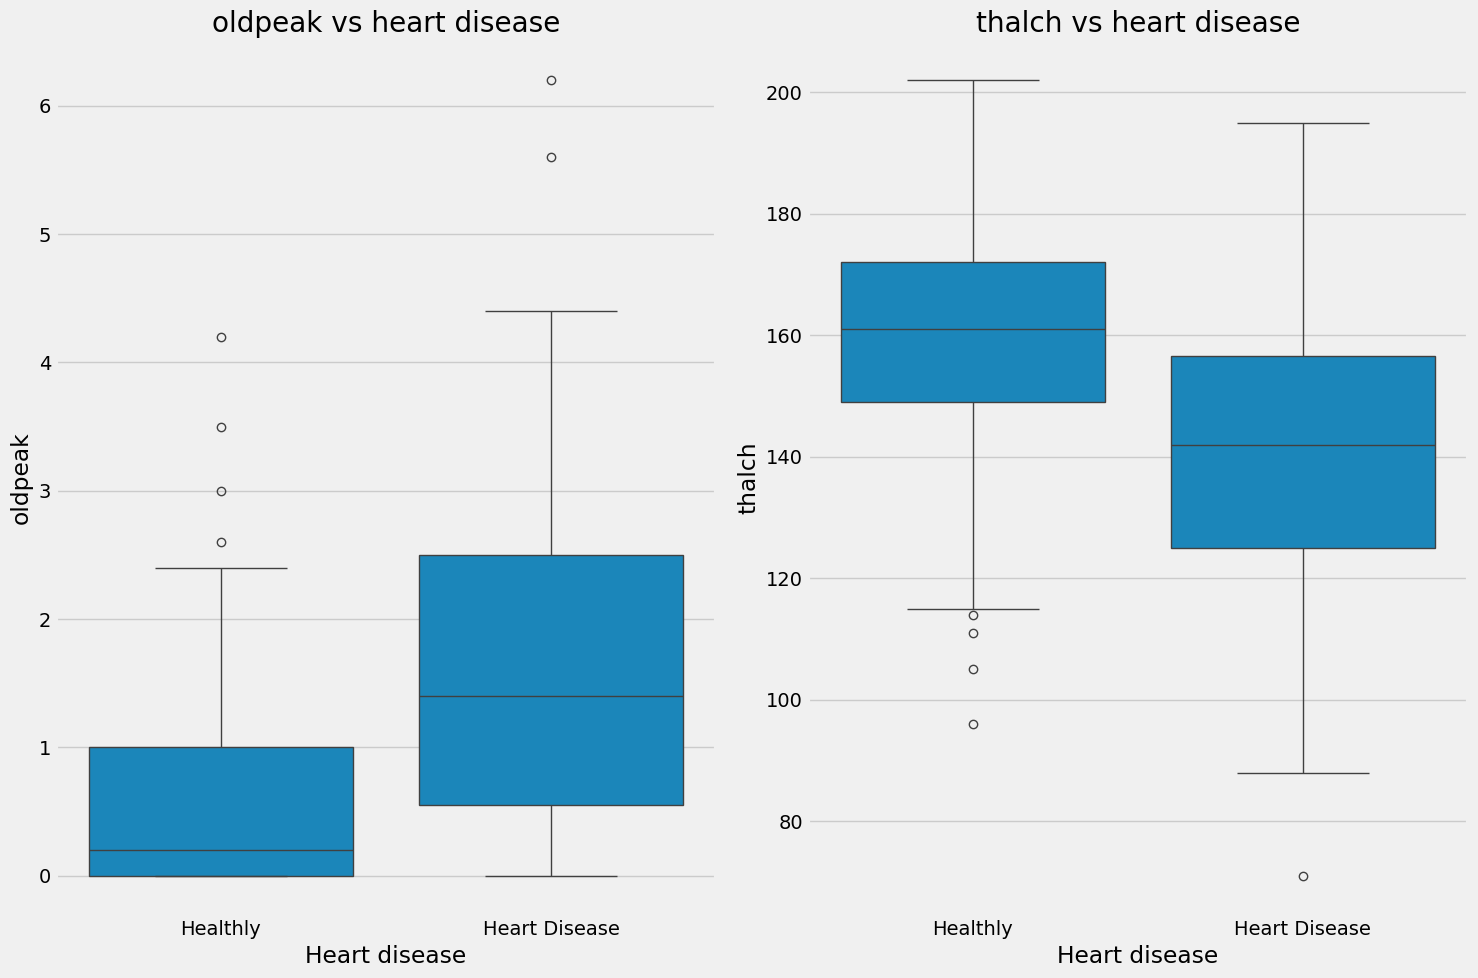

In [110]:
vars = ["oldpeak","thalch"]

fig, axes = plt.subplots(1,2, figsize=(15,10))
for i, var in enumerate(vars):
    # boxplot
    sns.boxplot(x="target", y=var, data=df, ax=axes[i])
    
 # Formatting
    axes[i].set_xlabel("Heart disease")
    axes[i].set_ylabel(f"{var}")
    axes[i].set_title(f'{var} vs heart disease')

    axes[i].set_xticks([x for x in target_label.keys()], 
               list(target_label.values()))

# Save figure   
dm.save_fig(fig_id= "cat_var_vs_target", image_directory=Path("outputs"))
    

**Barplots to compare healthy and heart disease patients at different levels of categorical variables**

Saving figure thal_vs_target
Saving figure cp_vs_target
Saving figure ca_vs_target
Saving figure exang_vs_target


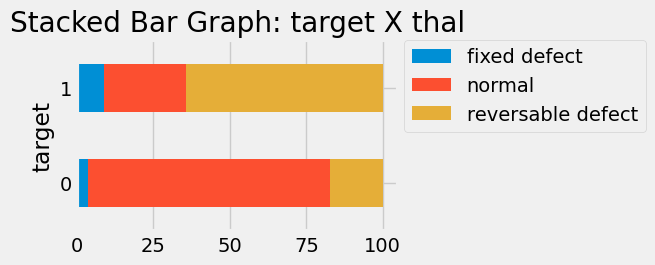

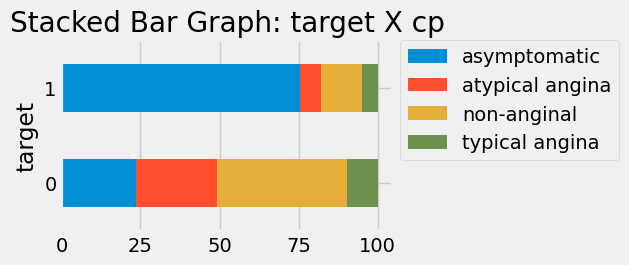

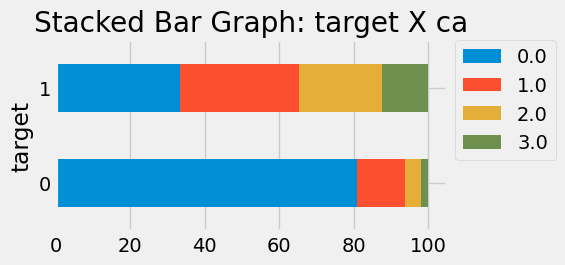

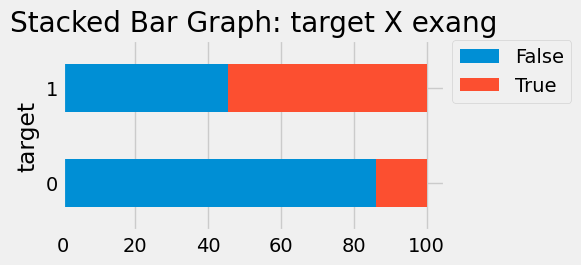

In [111]:
vars = ["thal","cp","ca","exang"]
for i, var in enumerate(vars):
    utils.cat_cat_stackplot(df,var,"target")

    # Save figure
    dm.save_fig(fig_id=f"{var}_vs_target", image_directory=Path("outputs"))

### Comments:
- Patients with heart disease are characterized by higher `oldpeak` (ST depression induced by exercise relative to rest), lower `thalch` (max heart rate achieved), having reversible defect in thalium stress test, having asymptomatic chest pain, having more than 1 major vessels colored by fluoroscopy, and having exercise induced angina.

**Check to see if numeric features are highly associated with each other**

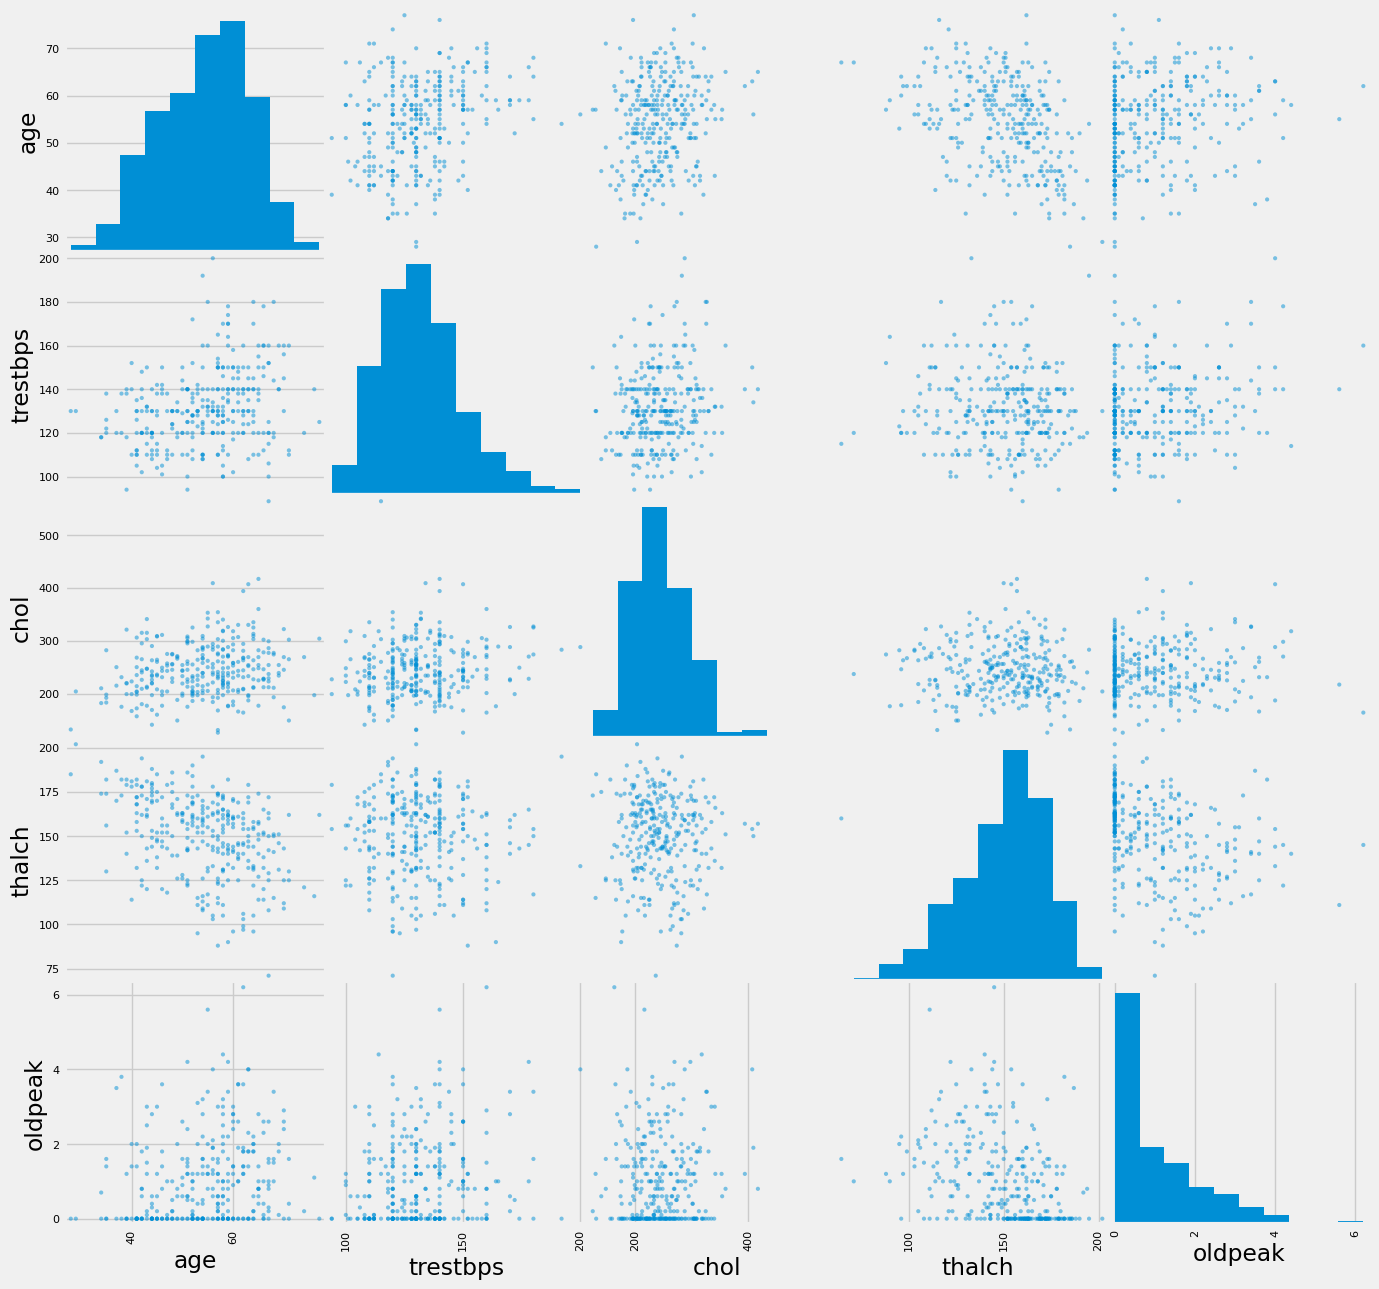

In [112]:
pd.plotting.scatter_matrix(df_numeric.loc[:,df_numeric.columns != "target"], figsize=(15,15));

Visually, I see some association amongst several variables:
- `thalach` and `age`
- `trestbps` and `age`
- `trestbps` and `chol`
- `thalach` and `age`
- `oldpeak` and `age`
- `oldpeak` and `thalch`    

**Check to see if sex (or age) mediates the association between the above "important" features (`thal`,`cp`,`ca`,`oldpeak`,`thalch`) and the target**
- Use logistic regression:
- Regress target on sex, feature, and sex*feature
- Regress target on age, feature, and age*feature

In [113]:
import statsmodels.formula.api as smf # statsmodels formula api

In [86]:
for dem in ["sex","age"]:
    for var in ["thal","cp","ca","oldpeak","thalch"]:
        clf = smf.logit(formula = f"target~{dem}*{var}",
                        data = df)
        # Fit model
        res = clf.fit() 
        print(res.summary())

         Current function value: 0.530109
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                  301
Model:                          Logit   Df Residuals:                      295
Method:                           MLE   Df Model:                            5
Date:                Thu, 05 Oct 2023   Pseudo R-squ.:                  0.2314
Time:                        08:13:37   Log-Likelihood:                -159.56
converged:                      False   LL-Null:                       -207.60
Covariance Type:            nonrobust   LLR p-value:                 3.555e-19
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                19.3326   1.58e+04      0.001      0.999   -3.09e

/Users/hfung/Documents/PycharmProjects/practice_projects/minor/heart_disease_prediction/dev/.heart_diease_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hfung/Documents/PycharmProjects/practice_projects/minor/heart_disease_prediction/dev/.heart_diease_env/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/hfung/Documents/PycharmProjects/practice_projects/minor/heart_disease_prediction/dev/.heart_diease_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hfung/Documents/PycharmProjects/practice_projects/minor/heart_disease_prediction/dev/.heart_dieas

### Comment:
- The only interaction term that is significant at the 5% level is age*thalch, but the coefficient is not substantial (log-odds = 0.0026). We will not interact any features with age and sex.

### We will perform feature engineering and selection, and modeling in the next notebook: `02-modeling.ipynb`